### Interest Rate Swap Pricer

Inputs:
a. Currency
b. Notional Schedule
c. Zero Rates *
d. Payment Freq
e. Daycount Fraction



Steps:
a. Take  

In [58]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from datetime import date
import os
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import requests
import time
from selenium import webdriver

In [20]:
def PullData(url):
    driver = webdriver.Chrome(executable_path=r"C:\Program Files (x86)\Google\Chrome\chromedriver.exe")
    driver.get(url)
    time.sleep(2)
    scroll_pause_time = 1
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1
    while True:
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        if (screen_height) * i > scroll_height:
            break
    while True:
        try:
            loadMoreButton = driver.find_element_by_class_name("tv-load-more__btn")
            loadMoreButton.click()
            time.sleep(5)
        except:
            break
    zero_rates = pd.read_html(driver.page_source)[1]
    driver.close()
    zero_rates = zero_rates.iloc[:,[0,2,3]].replace('—',np.nan).dropna()
    zero_rates.columns = ["Ticker","Maturity", "Yield"]
    zero_rates["Maturity"] = pd.to_datetime(zero_rates["Maturity"])
    zero_rates[["Yield"]] = zero_rates[["Yield"]].replace('−','-', regex=True)
    zero_rates.iloc[:,0] = zero_rates.iloc[:,0].apply(lambda x: x[0:5])
    zero_rates["Yield"] = pd.to_numeric(zero_rates["Yield"])
    return zero_rates

In [21]:
ticker_meta = pd.read_csv('ticker.csv')
url = "https://www.tradingview.com/markets/bonds/prices-all/"
zero_rates = PullData(url)
zero_rates.to_csv('zero_rates.csv', index=False)

In [22]:
zero_rates["T"] = zero_rates["Maturity"].apply(lambda x: ((x - dt.datetime.now()).days)/365)

In [23]:
zero_rates["Df"] = 1/(1+zero_rates["Yield"]/100)**zero_rates["T"]

In [25]:
zero_rates = pd.merge(zero_rates, ticker_meta).dropna()

In [26]:
zero_rates

,Ticker,Maturity,Yield,T,Df,Country,Currency,Tenor
0,AU01Y,2023-04-21,0.712,1.202740,0.991503,Australia,AUD,1.0
1,AU02Y,2024-04-21,1.048,2.205479,0.977269,Australia,AUD,2.0
2,AU03Y,2024-11-21,1.340,2.791781,0.963521,Australia,AUD,3.0
3,AU05Y,2026-09-21,1.757,4.624658,0.922609,Australia,AUD,5.0
4,AU07Y,2029-04-21,1.902,7.208219,0.873006,Australia,AUD,7.0
...,...,...,...,...,...,...,...,...
192,US05Y,2027-01-31,1.772,4.986301,0.916142,UnitedStates,USD,5.0
193,US07Y,2029-01-31,1.887,6.989041,0.877521,UnitedStates,USD,7.0
194,US10Y,2031-11-15,1.912,9.778082,0.830945,UnitedStates,USD,10.0
195,US20Y,2041-11-15,2.279,19.786301,0.640268,UnitedStates,USD,20.0


In [30]:
disc_factors = zero_rates.loc[:,["Currency", "T", "Df"]].reset_index(drop=True)

In [31]:
disc_factors

,Currency,T,Df
0,AUD,1.202740,0.991503
1,AUD,2.205479,0.977269
2,AUD,2.791781,0.963521
3,AUD,4.624658,0.922609
4,AUD,7.208219,0.873006
...,...,...,...
100,USD,4.986301,0.916142
101,USD,6.989041,0.877521
102,USD,9.778082,0.830945
103,USD,19.786301,0.640268


In [35]:
disc_factors[disc_factors.Currency == "USD"]

,Currency,T,Df
93,USD,0.082192,0.999966
94,USD,0.158904,0.999770
95,USD,0.241096,0.999432
96,USD,0.490411,0.997294
97,USD,0.969863,0.991586
98,USD,1.983562,0.974438
99,USD,2.942466,0.956028
100,USD,4.986301,0.916142
101,USD,6.989041,0.877521
102,USD,9.778082,0.830945


In [42]:
def Calc_FwdRate(StDate, Tenor, curr, TrDate = dt.date.today()):
    T1 = ((StDate - TrDate).days)/365
    T2 = T1 + Tenor
    dfTable = disc_factors[disc_factors.Currency == curr]
    return (np.interp(T1,dfTable['T'], dfTable['Df']) - np.interp(T2,dfTable['T'], dfTable['Df']))/((T2-T1)*np.interp(T2,dfTable['T'], dfTable['Df']))

In [ ]:
Calc_FwdRate()

In [50]:
Calc_FwdRate(dt.date.today() + dt.timedelta(days=1800), 0.25, "USD")

0.021191624643065697

In [80]:
spot = zero_rates[zero_rates["Currency"]==curr]["Yield"]
fwd3m, fwd6m, fwd1y = [], [], []
spottimelist = zero_rates[zero_rates["Currency"]==curr]["Tenor"]
timelist = np.linspace(0,20,80)
for i in timelist:
    fwd3m.append(Calc_FwdRate(dt.date.today() + dt.timedelta(days=i*365), 0.25, "USD"))
    fwd6m.append(Calc_FwdRate(dt.date.today() + dt.timedelta(days=i*365), 0.5, "USD"))
    fwd1y.append(Calc_FwdRate(dt.date.today() + dt.timedelta(days=i*365), 1, "USD"))

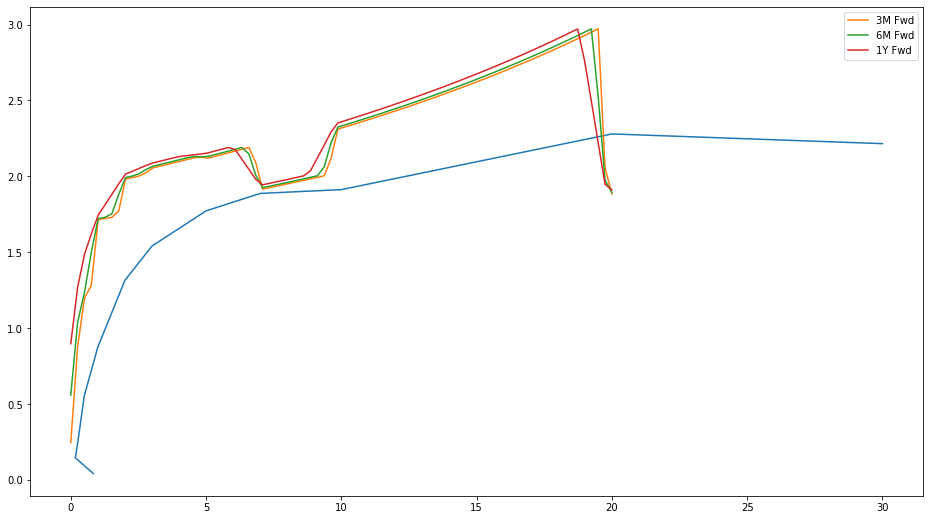

In [86]:
fig = plt.figure(figsize = (16,9)) 
plt.plot(spottimelist, spot)
plt.plot(timelist, np.dot(fwd3m,100), label = "3M Fwd")
plt.plot(timelist, np.dot(fwd6m,100), label = "6M Fwd")
plt.plot(timelist, np.dot(fwd1y,100), label = "1Y Fwd")
plt.legend()
plt.show()

In [9]:
curr = "USD"

In [55]:
zero_rates[zero_rates["Currency"]==curr]

,Ticker,Maturity,Yield,T,Df,Country,Currency,Tenor
185,US01M,2022-03-08,0.041,0.082192,0.999966,UnitedStates,USD,0.833
186,US02M,2022-04-05,0.145,0.158904,0.999770,UnitedStates,USD,0.167
187,US03M,2022-05-05,0.236,0.241096,0.999432,UnitedStates,USD,0.250
188,US06M,2022-08-04,0.554,0.490411,0.997294,UnitedStates,USD,0.500
189,US01Y,2023-01-26,0.875,0.969863,0.991586,UnitedStates,USD,1.000
190,US02Y,2024-01-31,1.314,1.983562,0.974438,UnitedStates,USD,2.000
191,US03Y,2025-01-15,1.540,2.942466,0.956028,UnitedStates,USD,3.000
192,US05Y,2027-01-31,1.772,4.986301,0.916142,UnitedStates,USD,5.000
193,US07Y,2029-01-31,1.887,6.989041,0.877521,UnitedStates,USD,7.000
194,US10Y,2031-11-15,1.912,9.778082,0.830945,UnitedStates,USD,10.000


In [13]:
zero_rates["T"][0] 

1.2027397260273973

In [40]:
dt.date.today() + dt.timedelta(days=5)

datetime.date(2022, 2, 10)

In [17]:
dt.datetime.now() + dt.timedelta(days=zero_rates["T"][0] *365)

datetime.datetime(2023, 4, 20, 13, 0, 45, 330597)

In [30]:
pd.read_csv('https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/all/202202?type=daily_treasury_yield_curve&field_tdr_date_value_month=202202&page&_format=csv')


,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,02/04/2022,0.05,0.12,0.23,0.56,0.89,1.31,1.55,1.78,1.90,1.93,2.29,2.23
1,02/03/2022,0.03,0.15,0.20,0.48,0.78,1.19,1.42,1.66,1.78,1.82,2.20,2.14
2,02/02/2022,0.04,0.10,0.19,0.45,0.76,1.16,1.38,1.60,1.74,1.78,2.17,2.11
3,02/01/2022,0.04,0.10,0.19,0.48,0.78,1.18,1.39,1.63,1.76,1.81,2.19,2.12
